# Document Classification with Hierarchical Clustering

### Step - 1: Prepare data to feed HAC

In [1]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

# set random seed
np.random.seed(seed = 4200)

# Fetch dataset without removing headers and footers 
newsgroups_train = fetch_20newsgroups(subset = "train")

# list of topics available in the dataset
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [3]:
# sample message from unaltered data
print(newsgroups_train.data[5700])

From: egreen@East.Sun.COM (Ed Green - Pixel Cruncher)
Subject: Re: Round Two
Organization: Sun Microsystems, RTP, NC
Lines: 22
Distribution: world
Reply-To: egreen@East.Sun.COM
NNTP-Posting-Host: laser.east.sun.com

In article 29788@serval.net.wsu.edu, bill@wsuaix.csc.wsu.edu (William E. Johns;S23015) writes:
>
>If Good Sam got 300 bricks, delivered
>first class postage to their door, at their expense, I bet they would change
>their policies about mailing lists or about who can use their facilities
>quickly. 

And if the Lord God Almighty parted the sky and make a personal
appearance at their Board of Directors meeting, they would also change
their policies.  The odds are about equal.

>I am curious as to how many bricks I will have to send before this situatiion
>is cleared up to my satisfaction.  I suspect about 5.  We shall see.

You'll be extremely lucky if you ever get one through.

---
Ed Green, former Ninjaite |I was drinking last night with a biker,
  Ed.Green@East.Sun.COM   |a

(array([10.,  0., 10.,  0.,  0., 10.,  0., 10.,  0., 10.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

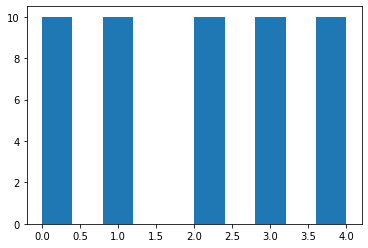

In [110]:
# Fetch dataset after removing headers and footers and specifying categories
newsgroups = fetch_20newsgroups(subset = "test", categories = [
 'comp.windows.x', 'talk.politics.mideast','rec.motorcycles','sci.crypt','misc.forsale'],  remove = ("headers"))

# make the dataset of managable size

class DataSubset:
    def __init__(self, data_set, subset):
        attrs = newsgroups.__dir__()
        for attr in attrs:
            values = getattr(data_set, attr)
            #print('length = {}'.format(len(values)))
            try:
                setattr(self, attr, [values[i] for i in subset])
            except:
                setattr(self, attr, values)
        
# uniformly pick indices for making a subset
subset, num_msg = [], 10
for label in np.unique(newsgroups.target):
    subset.extend(np.where(newsgroups.target == label)[0][ : num_msg])

# finally create our managable dataset
newsgrps = DataSubset(newsgroups, subset)

# sample message after removing the headers and footers
#print(len(newsgrps.target_names))
plt.hist(newsgrps.target, bins = 2*len(np.unique(newsgrps.target)))

### Step - 2: Vectorize text and create dendrogram

In [111]:
# vectorize text using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors_ = vectorizer.fit_transform(newsgrps.data)

# look at the number of total words in the collection of texts (= 114751)
print(vectors_.shape)

(50, 2914)


In [112]:
from scipy.cluster.hierarchy import dendrogram, linkage, single, ward, average
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances, manhattan_distances, euclidean_distances
from scipy.spatial.distance import pdist, squareform

import numpy as np
#print(vectors.todense())
vectors = vectors_.todense()
pd = pdist(vectors)
#np.fill_diagonal(pd, 0)
Z = ward(pd)
#print(pd.shape)
#vectors.dot(vectors.T)
#print(pd)

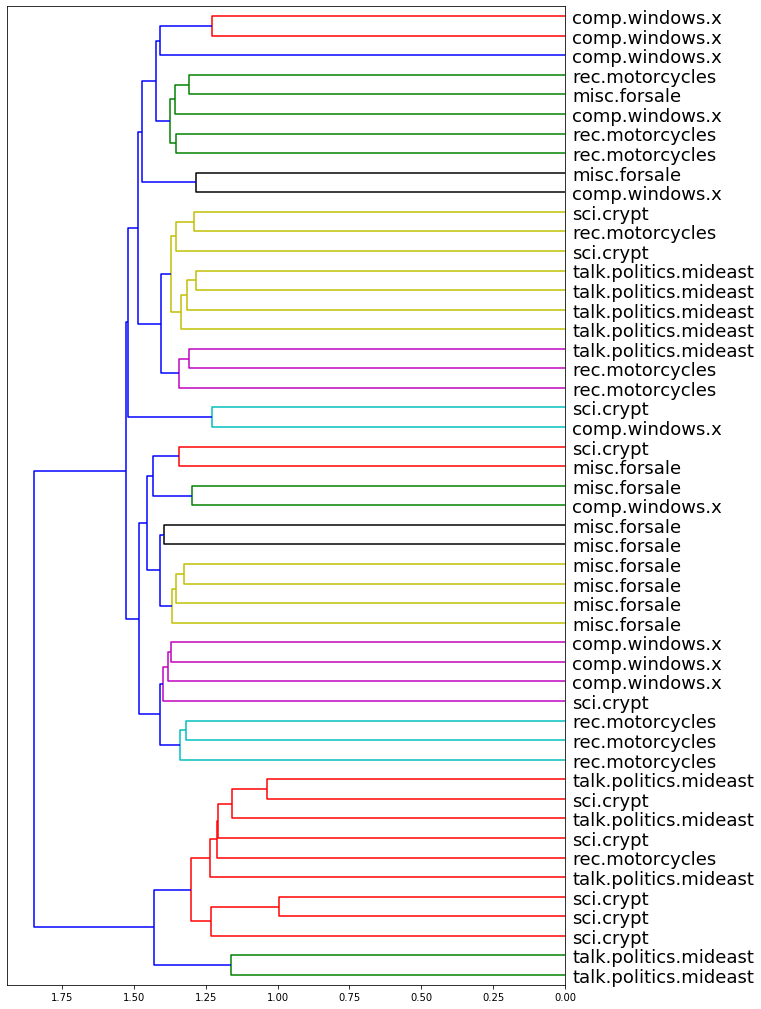

In [113]:
# figure out leaf labels 
fig = plt.figure(figsize =(10, 6*3))
ax = fig.add_subplot(1,1,1)

dendrogram(Z, ax=ax, show_contracted=True, leaf_font_size=18,\
           labels = [newsgrps.target_names[i] for i in newsgrps.target], orientation="left", color_threshold = 1.4)
plt.show()

### Step - 3: Find the optimal number of clusters using silhouette score and explore the optimal clusters

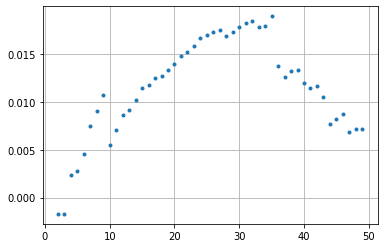

Optimal number of clusters = 35


In [114]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
k, ss = list(range(2, len(newsgrps.target))), []
#np.fill_diagonal(pd, 0)
for i in k:
    fl = fcluster(Z, t = i, criterion = 'maxclust')
    ss.append(silhouette_score(vectors_, fl))
plt.plot(k, ss,'.')
plt.grid()
plt.show()
print("Optimal number of clusters = {}".format(np.array(ss).argmax()+2))

In [115]:
from collections import Counter
clusters = [0]*20
cluster_labels = ['']*20 
for i in range(20):
    clusters[i] =  [j for j, k in enumerate(fl) if k == i+1]
    cluster_labels[i] = Counter([newsgrps.target[pt] for pt in clusters[i]]).most_common(1)[0][0]
        
misclassifications = 0
for i in range(20):
    for pt in clusters[i]:
        if cluster_labels[i] != newsgrps.target[pt]:
            misclassifications += 1
            
#print(misclassifications)

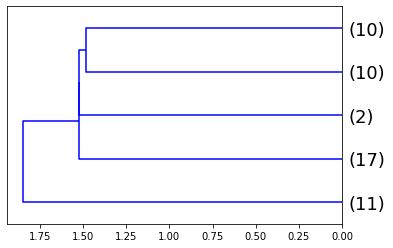

In [116]:
dendrogram(Z, truncate_mode='lastp', p = 5, leaf_font_size=18,\
            orientation="left", color_threshold = 1.4)
plt.show()


In [118]:
newsgrps.data[7]

'In article <1sofac$68m@zebedee.ingres.co.uk> supp60@ingres.com (Support account) writes:\n\n   In article <THOMAS.TORNBLOM.93May11115505@beck.Nexus.Comm.SE> Thomas.Tornblom@Nexus.Comm.SE (Thomas Tornblom) writes:\n   >I\'m trying to locate the Type1 rasterizer that IBM donated to The X\n   >consortium. I\'ve found patches to it but not the original source.\n\n   It\'s on the R5 "contrib" tape.\n\n   -Mike Glendinning, Ingres UK (mikeg@ingres.co.uk).\n\nYes I found it there. Thanks everyone.\n\nThomas\n--\nReal life:      Thomas Törnblom           Email:  Thomas.Tornblom@Nexus.Comm.SE\nSnail mail:     Communicator Nexus AB     Phone:  +46 18 171814\n                Box 857                   Fax:    +46 18 696516\n                S - 751 08 Uppsala, Sweden\n'